In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from IPython.display import clear_output
import pickle

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, LeakyReLU
from tensorflow.keras.layers import Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Reshape, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

from evaluation import Referee, load_data, select_dates, select_day_nums
# import functions from https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
from lightgbm_kernel import (reduce_mem_usage, read_data, encode_categorical, simple_fe, \
                            weight_calc, make_wrmsse, agg_series)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'
model_dir = 'models/uncertainty/'
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Any results you write to the current directory are saved as output.

data/.DS_Store
data/empty_pred.csv
data/pred_skeleton.csv
data/calendar.csv
data/sales_train_money.csv
data/sell_prices.csv
data/sales_train_validation.csv
data/sample_submission.csv
data/prep/converted_sales_level_12.csv
data/prep/converted_sales_level_11.csv
data/prep/converted_sales_level_10.csv
data/prep/converted_sales_all.csv
data/prep/norm_level_11.csv
data/prep/.DS_Store
data/prep/norm_level_10.csv
data/prep/norm_level_12.csv
data/prep/norm_level_1.csv
data/prep/norm_level_2.csv
data/prep/norm_level_3.csv
data/prep/norm_level_7.csv
data/prep/norm_level_6.csv
data/prep/converted_sales_level_9.csv
data/prep/norm_level_4.csv
data/prep/norm_level_5.csv
data/prep/converted_sales_level_8.csv
data/prep/converted_sales_level_5.csv
data/prep/norm_level_8.csv
data/prep/norm_level_9.csv
data/prep/converted_sales_level_4.csv
data/prep/converted_sales_level_6.csv
data/prep/converted_sales_level_7.csv
data/prep/simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle
data/prep/converted_sale

# Train MLP with DistributionLayer and WSPL through normalisation

In [91]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


## Data preparation (or read saved result)
From `lightgbm-poisson-w-scaled-pinball-loss.ipynb`.  

+ swapperooni with normalised sales. 

Note: categorical features are converted on-the-fly to reduce memory usage. 

In [31]:
converted_sales = pd.read_csv(data_dir + 'prep/converted_sales_level_12.csv', index_col=0)
converted_sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
d_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000549,0.000098,0.000000,...,0.0,0.003549,0.00033,0.0,0.002608,0.000000,0.0,0.000000,0.0,0.0
d_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000686,0.000000,0.000000,...,0.0,0.002789,0.00033,0.0,0.002608,0.000000,0.0,0.004826,0.0,0.0
d_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000343,0.000192,...,0.0,0.001268,0.00033,0.0,0.001304,0.000359,0.0,0.000000,0.0,0.0
d_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000147,0.000000,...,0.0,0.001521,0.00033,0.0,0.003260,0.000359,0.0,0.001609,0.0,0.0
d_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.001268,0.00033,0.0,0.001304,0.000000,0.0,0.001609,0.0,0.0


In [33]:
converted_sales = reduce_mem_usage(converted_sales.T)
converted_sales.head()

Mem. usage decreased to 112.73 Mb (74.8% reduction)


,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
HOBBIES_1_001_CA_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001548,0.004642,0.000000,0.001548,0.001548,0.001548,0.004642,0.000000,0.001548,0.001548
HOBBIES_1_002_CA_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000417,0.000000,0.000000,0.000000,0.000000
HOBBIES_1_003_CA_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000900,0.000450,0.000900,0.000450,0.000450,0.000450,0.000000,0.000450,0.000450,0.000450
HOBBIES_1_004_CA_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000694,0.000000,0.003471,0.002777,0.000694,0.000000,0.000694,0.002083,0.004860,0.001389
HOBBIES_1_005_CA_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000813,0.000407,0.000407,0.000000,0.000407,0.000407,0.000813,0.000813,0.000813,0.001627


In [13]:
calendar, sell_prices, sales_train_val, submission = read_data() # with memory reduction

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns


In [34]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [37]:
converted_sales.index.name = 'id'
converted_sales = converted_sales.reset_index()
converted_sales.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001548,0.004642,0.000000,0.001548,0.001548,0.001548,0.004642,0.000000,0.001548,0.001548
1,HOBBIES_1_002_CA_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000417,0.000000,0.000000,0.000000,0.000000
2,HOBBIES_1_003_CA_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000900,0.000450,0.000900,0.000450,0.000450,0.000450,0.000000,0.000450,0.000450,0.000450
3,HOBBIES_1_004_CA_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000694,0.000000,0.003471,0.002777,0.000694,0.000000,0.000694,0.002083,0.004860,0.001389
4,HOBBIES_1_005_CA_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000813,0.000407,0.000407,0.000000,0.000407,0.000407,0.000813,0.000813,0.000813,0.001627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3,0.0,0.000000,0.000359,0.000359,0.000000,0.000538,0.000179,0.000717,0.000179,...,0.000359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000179,0.000000,0.000000,0.000179
30486,FOODS_3_824_WI_3,0.0,0.000000,0.000000,0.000000,0.000000,0.000123,0.000000,0.000025,0.000025,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000025,0.000000
30487,FOODS_3_825_WI_3,0.0,0.004826,0.000000,0.001609,0.001609,0.003218,0.000804,0.006435,0.004021,...,0.001609,0.000804,0.000000,0.001609,0.000000,0.000804,0.000000,0.000000,0.000804,0.000000
30488,FOODS_3_826_WI_3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000286,0.000000,0.000000,0.000286,0.000000,0.000859,0.000286,0.000859


### Replace demand with normalised sales

In [40]:
d_cols = select_day_nums(converted_sales, as_int=False)
sales_train_val[d_cols] = converted_sales[d_cols]

In [41]:
del converted_sales
gc.collect()

18500

In [42]:
NUM_ITEMS = sales_train_val.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1   # 28

In [43]:
calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales_train_val = encode_categorical(
    sales_train_val, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"]).pipe(
    reduce_mem_usage
)

Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to 111.66 Mb (0.9% reduction)
Mem. usage decreased to 45.67 Mb (65.0% reduction)


In [44]:
nrows = 365 * 2 * NUM_ITEMS
nrows

22257700

In [45]:
sales_train_val = pd.melt(sales_train_val,
                          id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                          var_name = 'day', value_name = 'demand')
print('Melted sales train validation has {} rows and {} columns'.format(*sales_train_val.shape))

Melted sales train validation has 58327370 rows and 8 columns


In [46]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0.0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0.0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0.0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0.0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0.0


In [47]:
sales_train_val = sales_train_val.iloc[-nrows:,:]

In [48]:
# from https://www.kaggle.com/robertburbidge/lightgbm-poisson-w-scaled-pinball-loss
# separate test dataframes
forecast_submission = pd.concat([submission.iloc[0:int(771120/2),:].iloc[-30490:,:],submission.iloc[int(771120/2):,:].iloc[-30490:,:]])
forecast_submission['id'] = forecast_submission['id'].str.replace('_.\...._','_')
forecast_submission.drop_duplicates(inplace=True)

# submission fileのidのvalidation部分と, ealuation部分の名前を取得
test1_rows = [row for row in forecast_submission['id'] if 'validation' in row]
test2_rows = [row for row in forecast_submission['id'] if 'evaluation' in row]

# submission fileのvalidation部分をtest1, ealuation部分をtest2として取得
test1 = forecast_submission[forecast_submission['id'].isin(test1_rows)]
test2 = forecast_submission[forecast_submission['id'].isin(test2_rows)]

# test1, test2の列名の"F_X"の箇所をd_XXX"の形式に変更
test1.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
test2.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

# test2のidの'_evaluation'を置換
#test1['id'] = test1['id'].str.replace('_validation','')
test2['id'] = test2['id'].str.replace('_evaluation','_validation')

# sales_train_valからidの詳細部分(itemやdepartmentなどのid)を重複なく一意に取得。
product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

# idをキーにして, idの詳細部分をtest1, test2に結合する.
test1 = test1.merge(product, how = 'left', on = 'id')
test2 = test2.merge(product, how = 'left', on = 'id')

# test1, test2をともにmelt処理する.（売上数量:demandは0）
test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'demand')

test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'demand')

# validation部分と, evaluation部分がわかるようにpartという列を作り、 test1,test2のラベルを付ける。
sales_train_val['part'] = 'train'
test1['part'] = 'test1'
test2['part'] = 'test2'

# sales_train_valとtest1, test2の縦結合.
data = pd.concat([sales_train_val, test1, test2], axis = 0)

# memoryの開放
del test1, test2, sales_train_val, forecast_submission

# delete test2 for now(6/1以前は, validation部分のみ提出のため.)
data = data[data['part'] != 'test2']

gc.collect()

30

In [49]:
#calendarの結合
# drop some calendar features(不要な変数の削除:weekdayやwdayなどはdatetime変数から後ほど作成できる。)
calendar.drop(['weekday', 'wday', 'month', 'year'],
              inplace = True, axis = 1)

# notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)(dayとdをキーにdataに結合)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

# memoryの開放
del  calendar
gc.collect()

#sell priceの結合
# get the sell price data (this feature should be very important)
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

# memoryの開放
del  sell_prices
gc.collect()

Our final dataset to train has 22257700 rows and 18 columns


0

In [50]:
%%time
data = reduce_mem_usage(simple_fe(data, DAYS_PRED=DAYS_PRED))

Mem. usage decreased to 2356.15 Mb (46.4% reduction)
CPU times: user 12min 3s, sys: 1min 12s, total: 13min 15s
Wall time: 13min 21s


In [51]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [52]:
data.memory_usage()

Index                     178061600
id                        178061600
item_id                    44515400
dept_id                    22257700
cat_id                     22257700
store_id                   22257700
state_id                   22257700
demand                     44515400
part                      178061600
date                      178061600
wm_yr_wk                   44515400
event_name_1               44515400
event_type_1               44515400
event_name_2               44515400
event_type_2               44515400
snap_CA                    22257700
snap_TX                    22257700
snap_WI                    22257700
sell_price                 44515400
shift_t28                  44515400
shift_t29                  44515400
shift_t30                  44515400
rolling_std_t7             44515400
rolling_std_t30            44515400
rolling_std_t60            44515400
rolling_std_t90            44515400
rolling_std_t180           44515400
rolling_mean_t7            4

In [53]:
print("{:.2f} GB".format(data.memory_usage().sum() / 1024**3))

2.30 GB


### Save prepared dataset
Pickle chosen for its speed. See: https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d. 
Feather and parquet both require additional libraries (pyarrow). 

In [54]:
data.dtypes

id                                object
item_id                            int16
dept_id                             int8
cat_id                              int8
store_id                            int8
state_id                            int8
demand                           float16
part                              object
date                      datetime64[ns]
wm_yr_wk                           int16
event_name_1                     float16
event_type_1                     float16
event_name_2                     float16
event_type_2                     float16
snap_CA                             int8
snap_TX                             int8
snap_WI                             int8
sell_price                       float16
shift_t28                        float16
shift_t29                        float16
shift_t30                        float16
rolling_std_t7                   float16
rolling_std_t30                  float16
rolling_std_t60                  float16
rolling_std_t90 

In [55]:
fn = os.environ['DATA_DIR'] + 'prep/simple_fe_{}_{}_normalised_demand.pickle'.format(
    data.date.min().date().strftime("%Y_%m_%d"), data.date.max().date().strftime("%Y_%m_%d")
)
print("Saving to file..")
data.to_pickle(fn)
print("Finished.")

Saving to file..
Finished.


### Read prepared dataset

In [4]:
fn = data_dir + 'prep/simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle'
data = pd.read_pickle(fn)

In [5]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features.
    "shift_t28",
    "shift_t29",
    "shift_t30",
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_year_end",
    "is_year_start",
    "is_quarter_end",
    "is_quarter_start",
    "is_month_end",
    "is_month_start",
    "is_weekend"
]

In [6]:
data.head()[features]

,item_id,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,...,week,day,dayofweek,is_year_end,is_year_start,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend
0,1437,3,1,0,0,NaN,NaN,NaN,NaN,0,...,17,26,5,0,0,0,0,0,0,1
1,1438,3,1,0,0,NaN,NaN,NaN,NaN,0,...,17,26,5,0,0,0,0,0,0,1
2,1439,3,1,0,0,NaN,NaN,NaN,NaN,0,...,17,26,5,0,0,0,0,0,0,1
3,1440,3,1,0,0,NaN,NaN,NaN,NaN,0,...,17,26,5,0,0,0,0,0,0,1
4,1441,3,1,0,0,NaN,NaN,NaN,NaN,0,...,17,26,5,0,0,0,0,0,0,1


In [7]:
categorical_features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    # time features.
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
]

In [8]:
for col in categorical_features:
    data[col] = data[col].astype('category')

In [9]:
print("{:.2f} GB".format(data.memory_usage().sum() / 1024**3))

2.20 GB


## BatchCreator

In [10]:
class BatchCreator(Sequence):
    """Batch creator for M5 Uncertainty challenge.
    - batch_size: number of samples per batch. Note: if ensure_all_samples is True,
                  the final batch size may be smaller.
    - shuffle: whether to shuffle the samples.
    - ensure_all_samples: whether to ensure all samples are yielded. If False (default),
                          the batch size is always constant.
    - inp_shape: input shape of how a single sample enters the neural network. This is without the batch size.
    - categorical_features: which columns to convert to one-hot encoding
    """

    def __init__(self, df, features, labels, batch_size=128, shuffle=True, ensure_all_samples=False,
                 inp_shape=(3244,), out_shape=(9,), categorical_features=None):
        """Initialization"""
        # Save settings
        self.df = df
        self.list_IDs = self.df.index
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.ensure_all_samples = ensure_all_samples
        self.inp_shape = inp_shape
        self.out_shape = out_shape
        self.categorical_features = categorical_features
        
        # initialize indices
        self.indexes = None
        self.on_epoch_end()

        # calculate properties
        self.n = self.df.index.size

    def __len__(self):
        """Denotes the number of batches per epoch"""
        if self.ensure_all_samples:
            return int(np.ceil(self.n / self.batch_size))
        return self.n // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = self.list_IDs[indexes]

        # Generate data
        x_batch, y_batch = self.__data_generation(list_IDs_temp)

        return x_batch, y_batch

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        
        # fill labels
        demand = self.df.loc[list_IDs_temp, 'demand'].values.astype(np.float32)
        y_batch = {'q%d'%d: demand for d in range(9)}

        # fill features
        x_batch = self.df.loc[list_IDs_temp, self.features]
        x_batch = pd.get_dummies(x_batch, columns=self.categorical_features)#, dummy_na=True)
        x_batch = x_batch.replace(np.nan, 0)
        x_batch = x_batch.values

        return x_batch, y_batch

    def flow(self, epochs=None):
        """returns a generator that will yield batches infinitely"""
        epochs_done = 0
        while True:
            for index in range(self.__len__()):
                batch_x, batch_y = self.__getitem__(index)
                yield batch_x, batch_y

            # track nr. of epochs
            epochs_done += 1
            if epochs is not None and epochs_done == epochs:
                break # stop yielding new elements

            # do on epoch end
            self.on_epoch_end()

In [11]:
# going to evaluate with the last 28 days
train_df = data[data['date'] <= '2016-03-27']
val_df = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
test_df = data[(data['date'] > '2016-04-24')]

train_df.index.size, val_df.index.size, test_df.index.size

(21403980, 853720, 0)

In [12]:
labels = ['demand']
batch_size = 25000
train_batch_creator = BatchCreator(train_df, features, labels, categorical_features=categorical_features,
                                  batch_size=batch_size)
val_batch_creator = BatchCreator(val_df, features, labels, shuffle=False, ensure_all_samples=True,
                                 categorical_features=categorical_features, batch_size=batch_size)

## Initialize pinball loss

In [13]:
# from Daniel Sch., at:
# https://stackoverflow.com/questions/43151694/define-pinball-loss-function-in-keras-with-tensorflow-backend
def create_pinball_loss(tau=0.5):
    def pinball_loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return pinball_loss

In [14]:
losses = {'q'+str(i): create_pinball_loss(tau=q) for (i, q) in enumerate(quantiles)}
losses

{'q0': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q1': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q2': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q3': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q4': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q5': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q6': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q7': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>,
 'q8': <function __main__.create_pinball_loss.<locals>.pinball_loss(y_true, y_pred)>}

## Logger

In [15]:
class Logger(Callback):
    def __init__(self, val_batch_creator, update_plot=True):
        super().__init__()
        self.val_batch_creator = val_batch_creator
        self.update_plot = update_plot

        # validation metrics
        self.val_x = []
        self.val_spl = []
        # save best model properties
        self.best_spl = np.inf
        self.best_model = None
        self.best_epoch = 0
        
        # initialize metrics
        self.train_metrics = {}
        self.metric_names = ['loss']
        self.metric_names.extend(['q{}_loss'.format(d) for d in range(9)])
        for m in self.metric_names:
            self.train_metrics[m] = []
        print("Tracking {}".format(self.metric_names))
        
        self.val_metrics = {}
        self.val_metric_names = ['val_{}'.format(m) for m in self.metric_names]
        for m in self.val_metric_names:
            self.val_metrics[m] = []
        print("Tracking {}".format(self.val_metric_names))

    def on_batch_end(self, batch, logs={}):
        # log training metrics
        for m in self.metric_names:
            if m in logs.keys():
                self.train_metrics[m].append(logs.get(m))

    def on_epoch_end(self, batch, logs={}):
        num_train_steps = len(self.train_metrics['loss'])
        self.model.save(model_dir + 'dist_model_{}_steps.h5'.format(num_train_steps))
        
        # calculate normalised validation PL
        if 'val_loss' in logs.keys():
            for m in self.val_metric_names:
                self.val_metrics[m].append(logs.get(m))
        else:
            # evaluate validation set
            val_losses = self.model.evaluate(self.val_batch_creator.flow(), 
                                             steps=val_batch_creator.__len__())
            for i, m in self.val_metric_names:
                self.val_metrics[m] = val_losses[i]
        
        self.val_x.append(num_train_steps)
        spl = self.val_metrics['val_loss'][-1]

        if spl < self.best_spl:
            self.best_spl = spl
            self.best_model = self.model.get_weights()
            self.best_epoch = len(self.val_spl)
        if self.update_plot:
            self.plot()

    def validate(self):
        pass

    def plot(self, experimental_pinball_boost=7.687106850995075/0.0018890968224565899, clear=True):
        if clear:
            clear_output()

        f, axes2d = plt.subplots(2, 2, figsize=(18, 12))

        # plot losses
        losses = self.train_metrics['loss']
        val_losses = self.val_metrics['val_loss']
        
        for i, axes in enumerate(axes2d):
            if i == 1:
                # experimental: convert normalised PL -> WSPL
                losses = losses * experimental_pinball_boost
                val_losses = val_losses * experimental_pinball_boost
            
            ax = axes[0]
            ax.plot(range(1, 1+len(losses)), losses, label='Train')
            if len(val_losses):
                ax.plot(self.val_x, val_losses, '.-', label='Validation')
            ax.set_xlabel("Step")
            ax.set_ylabel(r"normalised PL")
            ax.set_title("Loss")
            ax.set_ylim(0)

            # plot final losses
            ax = axes[1]
            N = len(losses)
            n = min(1001, N)
            ax.plot(range(1+N-n, 1+N), losses[-n:], label='Train')
            if len(val_losses):
                indexer = [x > (N-n) for x in logger.val_x]
                ax.plot(np.array(self.val_x)[indexer], np.array(val_losses)[indexer], '.-', label='Validation')
            ax.set_xlabel("Step")
            ax.set_ylabel(r"normalised PL")
            ax.set_title("Loss final {} steps".format(n))
            ax.set_ylim(0)

            for ax in axes:
                ax.legend()

        plt.show()

In [16]:
logger = Logger(val_batch_creator)

Tracking ['loss', 'q0_loss', 'q1_loss', 'q2_loss', 'q3_loss', 'q4_loss', 'q5_loss', 'q6_loss', 'q7_loss', 'q8_loss']
Tracking ['val_loss', 'val_q0_loss', 'val_q1_loss', 'val_q2_loss', 'val_q3_loss', 'val_q4_loss', 'val_q5_loss', 'val_q6_loss', 'val_q7_loss', 'val_q8_loss']


## Build model

In [17]:
# from https://www.wolframalpha.com/input/?i=percentiles+of+a+normal+distribution
sigma_coefs = [-2.57583, -1.95996, -0.974114, -0.674, 0, 0.674, 0.9741114, 1.95996, 2.57583]

# Lambda layer: https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/
def get_custom_layer(sigma_coef):
    def custom_layer(tensor):
        tensor1 = tensor[0]
        tensor2 = tensor[1]
        return tensor1 + sigma_coef * tensor2

    return custom_layer

def get_dist_model(inp_shape, sigma_coefs):
    # clear previous sessions
    K.clear_session()

    inp = Input(inp_shape, name="input")
    x = inp
    x = Dense(64)(x)
    x = Dense(64)(x)
    x = Dense(64)(x)
    
    mu = Dense(1)(x)  # represents mu
    sigma = Dense(1)(x)  # represents sigma
    
    outs = []

    for i, sigma_coef in enumerate(sigma_coefs):
        custom_layer = get_custom_layer(sigma_coef=sigma_coef)
        out_q = Lambda(custom_layer, name="q{}".format(i))([mu, sigma])
        outs.append(out_q)

    model = Model(inputs=inp, outputs=outs) 

    return model

In [18]:
model = get_dist_model(inp_shape=(3244,), sigma_coefs=sigma_coefs)
model.compile(optimizer="adam", loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3244)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           207680      input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

### Train model

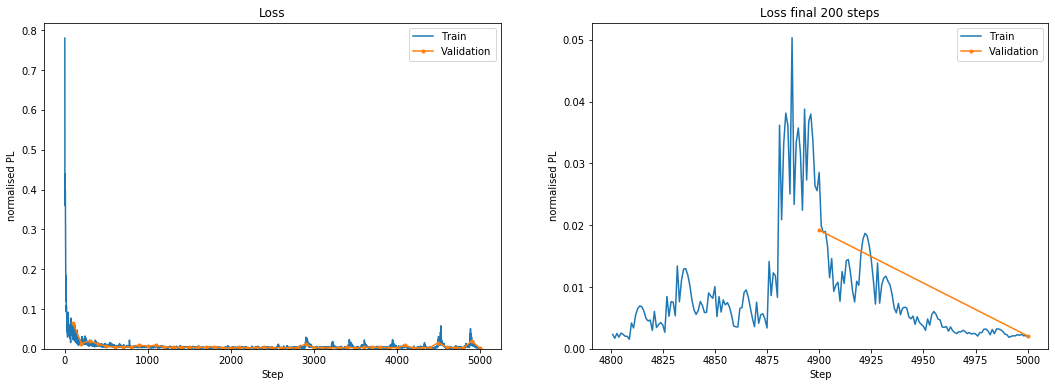

100/100 [==============================] - 358s 4s/step - loss: 0.0068 - q0_loss: 1.9947e-04 - q1_loss: 4.1119e-04 - q2_loss: 0.0011 - q3_loss: 0.0013 - q4_loss: 9.3558e-04 - q5_loss: 0.0011 - q6_loss: 0.0011 - q7_loss: 4.0485e-04 - q8_loss: 1.9945e-04 - val_loss: 0.0021 - val_q0_loss: 2.3552e-05 - val_q1_loss: 7.1458e-05 - val_q2_loss: 2.5361e-04 - val_q3_loss: 3.1260e-04 - val_q4_loss: 4.2723e-04 - val_q5_loss: 4.4309e-04 - val_q6_loss: 3.7499e-04 - val_q7_loss: 1.2465e-04 - val_q8_loss: 5.2608e-05


In [20]:
# NOTE: Setting steps/epoch to 100 to evaluate more often
# note: full evaluation takes about a minute

history = model.fit(train_batch_creator.flow(), epochs=50,
                    steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(),
                    validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

In [24]:
with open(model_dir + 'dist_model_best.pickle', 'wb') as handle:
    pickle.dump(logger.best_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load best trained model (lowest validation loss)

In [21]:
with open(model_dir + 'dist_model_best.pickle', 'rb') as handle:
    w = pickle.load(handle)
model.set_weights(w)

In [22]:
model.evaluate(val_batch_creator, verbose=1)

35/35 [==============================] - 69s 2s/step - loss: 0.0019 - q0_loss: 2.0073e-05 - q1_loss: 6.7444e-05 - q2_loss: 2.4579e-04 - q3_loss: 3.0602e-04 - q4_loss: 3.9243e-04 - q5_loss: 3.8036e-04 - q6_loss: 3.2348e-04 - q7_loss: 1.0855e-04 - q8_loss: 4.4942e-05


[0.0018890968224565899,
 2.0072865e-05,
 6.744403e-05,
 0.00024578566,
 0.00030602064,
 0.00039243244,
 0.00038036495,
 0.00032348168,
 0.00010855305,
 4.494156e-05]

In [23]:
verbose=True
# predict
if verbose: print("Predicting...")
y_pred = model.predict(val_batch_creator.flow(epochs=1))

# from lightgbm-poisson-w-scaled-pinball-loss.ipynb
if verbose: print("Converting predictions...")
df = val_df
ids = df['id'].unique()
day_start = np.datetime64(df.date.min().date())
day_end = np.datetime64(df.date.max().date())
num_days = (day_end - day_start + 1).astype(int)

y_pred_df_list = []

for i, q in enumerate(quantiles):
    y_pred_df = pd.DataFrame.from_dict({
        'id': np.repeat(ids, num_days),
        'date': np.tile(np.arange(day_start, day_end+1),30490),
        'pred': y_pred[i].squeeze(),
        'demand': df['demand'],
    })

    y_pred_df['quantile'] = "{:.3f}".format(q)
    y_pred_df['item_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:3]))
    y_pred_df['dept_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:2]))
    y_pred_df['cat_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:1]))
    y_pred_df['store_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:5]))
    y_pred_df['state_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:4]))

    y_pred_df_list.append(y_pred_df)

# combine quantiles
if verbose: print("Combining predictions...")
y_pred_df = pd.concat(y_pred_df_list)

# pivot and set quantile / level
if verbose: print("Pivoting predictions...")
df = y_pred_df
df['id'] = df['id'] + df['quantile']
df = df.pivot(index='id', columns='date', values='pred')
df = df.reset_index()
df['quantile'] = df.apply(lambda row: float(row.id[-5:]), axis=1)
df['id'] = df.apply(lambda row: row.id[:-5], axis=1)
df['level'] = 12
df = df.set_index('id')

Predicting...
Converting predictions...
Combining predictions...
Pivoting predictions...


In [24]:
df.head()

date,2016-03-28 00:00:00,2016-03-29 00:00:00,2016-03-30 00:00:00,2016-03-31 00:00:00,2016-04-01 00:00:00,2016-04-02 00:00:00,2016-04-03 00:00:00,2016-04-04 00:00:00,2016-04-05 00:00:00,2016-04-06 00:00:00,...,2016-04-17 00:00:00,2016-04-18 00:00:00,2016-04-19 00:00:00,2016-04-20 00:00:00,2016-04-21 00:00:00,2016-04-22 00:00:00,2016-04-23 00:00:00,2016-04-24 00:00:00,quantile,level
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,-0.011736,-0.002368,-0.002774,-0.002746,-0.002617,-0.004651,-0.002223,-0.005998,-0.003293,-0.001957,...,-0.002257,-0.002090,-0.001260,-0.003097,-0.002643,-0.002106,-0.012476,-0.003656,0.005,12
FOODS_1_001_CA_1_validation,-0.005732,-0.001593,-0.001752,-0.001983,-0.001620,-0.002945,-0.001623,-0.004313,-0.002585,-0.001568,...,-0.001750,-0.001463,-0.000933,-0.002428,-0.001955,-0.001564,-0.005532,-0.002734,0.025,12
FOODS_1_001_CA_1_validation,0.003877,-0.000351,-0.000116,-0.000762,-0.000022,-0.000213,-0.000664,-0.001615,-0.001451,-0.000947,...,-0.000940,-0.000458,-0.000410,-0.001356,-0.000854,-0.000697,0.005582,-0.001259,0.165,12
FOODS_1_001_CA_1_validation,0.006803,0.000026,0.000382,-0.000391,0.000464,0.000619,-0.000371,-0.000794,-0.001106,-0.000757,...,-0.000693,-0.000152,-0.000251,-0.001030,-0.000519,-0.000433,0.008966,-0.000810,0.250,12
FOODS_1_001_CA_1_validation,0.013373,0.000875,0.001500,0.000444,0.001556,0.002486,0.000285,0.001050,-0.000331,-0.000332,...,-0.000138,0.000535,0.000107,-0.000297,0.000233,0.000159,0.016564,0.000199,0.500,12


In [25]:
norm = pd.read_csv(data_dir + 'prep/norm_level_12.csv', index_col='id')
norm.index = norm.index + '_validation'
norm.head()

,norm
id,
HOBBIES_1_001_CA_1_validation,645.993994
HOBBIES_1_002_CA_1_validation,2398.441029
HOBBIES_1_003_CA_1_validation,2223.057555
HOBBIES_1_004_CA_1_validation,1440.585075
HOBBIES_1_005_CA_1_validation,2459.273994


In [62]:
df.shape

(274410, 30)

In [63]:
%%time
denorm_df = df.apply(lambda row: row * norm.loc[row.index].norm, axis=0)
denorm_df[['quantile', 'level']] = df[['quantile', 'level']]
denorm_df.head(13)

CPU times: user 2.11 s, sys: 68.3 ms, total: 2.18 s
Wall time: 2.19 s


date,2016-03-28 00:00:00,2016-03-29 00:00:00,2016-03-30 00:00:00,2016-03-31 00:00:00,2016-04-01 00:00:00,2016-04-02 00:00:00,2016-04-03 00:00:00,2016-04-04 00:00:00,2016-04-05 00:00:00,2016-04-06 00:00:00,...,2016-04-17 00:00:00,2016-04-18 00:00:00,2016-04-19 00:00:00,2016-04-20 00:00:00,2016-04-21 00:00:00,2016-04-22 00:00:00,2016-04-23 00:00:00,2016-04-24 00:00:00,quantile,level
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,-44.408711,-8.961002,-10.497504,-10.392156,-9.903996,-17.599180,-8.410078,-22.697082,-12.460219,-7.403562,...,-8.540273,-7.909463,-4.769231,-11.719272,-9.999540,-7.968021,-47.208290,-13.833481,0.005,12
FOODS_1_001_CA_1_validation,-21.691570,-6.026744,-6.630039,-7.505626,-6.128406,-11.142127,-6.141839,-16.319895,-9.780279,-5.934005,...,-6.623526,-5.534653,-3.531816,-9.186152,-7.397717,-5.918720,-20.934407,-10.346140,0.025,12
FOODS_1_001_CA_1_validation,14.672600,-1.329770,-0.439245,-2.885052,-0.084678,-0.806080,-2.510983,-6.111695,-5.490398,-3.581630,...,-3.555319,-1.733207,-1.551041,-5.131291,-3.232885,-2.638330,21.123179,-4.763824,0.165,12
FOODS_1_001_CA_1_validation,25.742683,0.100096,1.445374,-1.478443,1.755171,2.340447,-1.405668,-3.004087,-4.184460,-2.865514,...,-2.621287,-0.575960,-0.948047,-3.896899,-1.965016,-1.639704,33.926467,-3.064440,0.250,12
FOODS_1_001_CA_1_validation,50.604024,3.311309,5.677877,1.680536,5.887128,9.406962,1.076664,3.975022,-1.251569,-1.257250,...,-0.523624,2.023001,0.406163,-1.124685,0.882384,0.603023,62.680263,0.752060,0.500,12
FOODS_1_001_CA_1_validation,75.465370,6.522521,9.910380,4.839516,10.019085,16.473477,3.558995,10.954130,1.681323,0.351014,...,1.574038,4.621961,1.760373,1.647529,3.729782,2.845750,91.434059,4.568560,0.750,12
FOODS_1_001_CA_1_validation,86.535350,7.952374,11.794982,6.246112,11.858917,19.619978,4.664301,14.061711,2.987249,1.067124,...,2.508062,5.779198,2.363361,2.881911,4.997641,3.844367,104.237230,6.267929,0.835,12
FOODS_1_001_CA_1_validation,122.899615,12.649361,17.985793,10.866699,17.902661,29.956051,8.295165,24.269939,7.277140,3.419505,...,5.576277,9.580654,4.344143,6.936782,9.162485,7.124766,146.294940,11.850259,0.975,12
FOODS_1_001_CA_1_validation,145.616763,15.583618,21.853259,13.753228,21.678252,36.413103,10.563406,30.647126,9.957081,4.889062,...,7.493023,11.955464,5.581557,9.469904,11.764306,9.174066,172.568816,15.337600,0.995,12


In [71]:
cols = list(df.columns)
target_d_cols = select_day_nums(ref.sales_true, as_int=False)
cols[:len(target_d_cols)] = target_d_cols
denorm_df.columns = cols
denorm_df.head(13)

,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,...,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,quantile,level
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,-44.408711,-8.961002,-10.497504,-10.392156,-9.903996,-17.599180,-8.410078,-22.697082,-12.460219,-7.403562,...,-8.540273,-7.909463,-4.769231,-11.719272,-9.999540,-7.968021,-47.208290,-13.833481,0.005,12
FOODS_1_001_CA_1_validation,-21.691570,-6.026744,-6.630039,-7.505626,-6.128406,-11.142127,-6.141839,-16.319895,-9.780279,-5.934005,...,-6.623526,-5.534653,-3.531816,-9.186152,-7.397717,-5.918720,-20.934407,-10.346140,0.025,12
FOODS_1_001_CA_1_validation,14.672600,-1.329770,-0.439245,-2.885052,-0.084678,-0.806080,-2.510983,-6.111695,-5.490398,-3.581630,...,-3.555319,-1.733207,-1.551041,-5.131291,-3.232885,-2.638330,21.123179,-4.763824,0.165,12
FOODS_1_001_CA_1_validation,25.742683,0.100096,1.445374,-1.478443,1.755171,2.340447,-1.405668,-3.004087,-4.184460,-2.865514,...,-2.621287,-0.575960,-0.948047,-3.896899,-1.965016,-1.639704,33.926467,-3.064440,0.250,12
FOODS_1_001_CA_1_validation,50.604024,3.311309,5.677877,1.680536,5.887128,9.406962,1.076664,3.975022,-1.251569,-1.257250,...,-0.523624,2.023001,0.406163,-1.124685,0.882384,0.603023,62.680263,0.752060,0.500,12
FOODS_1_001_CA_1_validation,75.465370,6.522521,9.910380,4.839516,10.019085,16.473477,3.558995,10.954130,1.681323,0.351014,...,1.574038,4.621961,1.760373,1.647529,3.729782,2.845750,91.434059,4.568560,0.750,12
FOODS_1_001_CA_1_validation,86.535350,7.952374,11.794982,6.246112,11.858917,19.619978,4.664301,14.061711,2.987249,1.067124,...,2.508062,5.779198,2.363361,2.881911,4.997641,3.844367,104.237230,6.267929,0.835,12
FOODS_1_001_CA_1_validation,122.899615,12.649361,17.985793,10.866699,17.902661,29.956051,8.295165,24.269939,7.277140,3.419505,...,5.576277,9.580654,4.344143,6.936782,9.162485,7.124766,146.294940,11.850259,0.975,12
FOODS_1_001_CA_1_validation,145.616763,15.583618,21.853259,13.753228,21.678252,36.413103,10.563406,30.647126,9.957081,4.889062,...,7.493023,11.955464,5.581557,9.469904,11.764306,9.174066,172.568816,15.337600,0.995,12


In [77]:
denorm_df.to_pickle(sub_dir + 'almost_evaluation_ready.pickle')

In [65]:
ref.sales_true.columns

Index(['d_1886', 'd_1887', 'd_1888', 'd_1889', 'd_1890', 'd_1891', 'd_1892',
       'd_1893', 'd_1894', 'd_1895', 'd_1896', 'd_1897', 'd_1898', 'd_1899',
       'd_1900', 'd_1901', 'd_1902', 'd_1903', 'd_1904', 'd_1905', 'd_1906',
       'd_1907', 'd_1908', 'd_1909', 'd_1910', 'd_1911', 'd_1912', 'd_1913',
       'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
      dtype='object')

In [96]:
metrics = ref.evaluate_WSPL(denorm_df)
metrics

{12: 7.687106850995075, 'WSPL': 7.687106850995075}

In [97]:
metrics = ref.evaluate_WSPL(denorm_df.clip(lower=0))
metrics

{12: 5.792130862138171, 'WSPL': 5.792130862138171}

In [101]:
def evaluate_model_normed_level_12(model, ref, val_batch_creator, val_df, sales_true, clip_zero=True, verbose=True):
    # predict
    if verbose: print("Predicting...")
    y_pred = model.predict(val_batch_creator.flow(epochs=1))
    
    # from lightgbm-poisson-w-scaled-pinball-loss.ipynb
    if verbose: print("Converting predictions...")
    df = val_df
    ids = df['id'].unique()
    day_start = np.datetime64(df.date.min().date())
    day_end = np.datetime64(df.date.max().date())
    num_days = (day_end - day_start + 1).astype(int)

    y_pred_df_list = []

    for i, q in enumerate(quantiles):
        y_pred_df = pd.DataFrame.from_dict({
            'id': np.repeat(ids, num_days),
            'date': np.tile(np.arange(day_start, day_end+1),30490),
            'pred': y_pred[i].squeeze(),
            'demand': df['demand'],
        })

        y_pred_df['quantile'] = "{:.3f}".format(q)
        y_pred_df['item_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:3]))
        y_pred_df['dept_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:2]))
        y_pred_df['cat_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[0:1]))
        y_pred_df['store_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:5]))
        y_pred_df['state_id'] = y_pred_df['id'].map(lambda x: '_'.join(x.split('_')[3:4]))

        y_pred_df_list.append(y_pred_df)
    
    # combine quantiles
    if verbose: print("Combining predictions...")
    y_pred_df = pd.concat(y_pred_df_list)
    
    # pivot and set quantile / level
    if verbose: print("Pivoting predictions...")
    df = y_pred_df
    df['id'] = df['id'] + df['quantile']  # store quantile with index for later splitting
    df = df.pivot(index='id', columns='date', values='pred')
    df = df.reset_index()
    df['quantile'] = df.apply(lambda row: float(row.id[-5:]), axis=1)
    df['id'] = df.apply(lambda row: row.id[:-5], axis=1)  # split quantile from index
    df['level'] = 12
    df = df.set_index('id')
    
    # read normalisation constants
    verbose: print("Denormalising...")
    norm = pd.read_csv(data_dir + 'prep/norm_level_12.csv', index_col='id')
    norm.index = norm.index + '_validation'
    
    # de-normalise
    denorm_df = df.apply(lambda row: row * norm.loc[row.index].norm, axis=0)
    denorm_df[['quantile', 'level']] = df[['quantile', 'level']]
    
    # change column names for evaluation
    if verbose: print("Assuming date range is correct, changing column names...")
    cols = list(denorm_df.columns)
    target_d_cols = select_day_nums(ref.sales_true, as_int=False)
    cols[:len(target_d_cols)] = target_d_cols
    denorm_df.columns = cols
    
    if clip_zero:
        if verbose: print("Clipping predictions to zero...")
        denorm_df = denorm_df.clip(lower=0)
    
    if verbose: print("Evaluating predictions...")
    metrics = ref.evaluate_WSPL(denorm_df)
    
    if verbose: print(metrics)
    
    return metrics

In [102]:
%%time
metrics = evaluate_model_normed_level_12(model, ref, val_batch_creator, val_df, sales_true)

Predicting...
Converting predictions...
Combining predictions...
Pivoting predictions...
Assuming date range is correct, changing column names...
Clipping predictions to zero...
Evaluating predictions...
{12: 5.792130862138171, 'WSPL': 5.792130862138171}
